# Imports

In [1]:
!nvidia-smi

Fri Jul 31 10:47:28 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
# We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py
!pip install sentencepiece

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import Sequential
import tensorflow_hub as hub

import re
import tokenization
import string
import os
"""
from keras import backend as K
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, Flatten
from keras.layers import LSTM
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import hashing_trick
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
"""
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn import metrics

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Cargar data

In [4]:
to_predict = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv').fillna(' ')
to_predict['complete_text'] = to_predict['keyword'] + ' ' + to_predict['location'] + ' ' + to_predict['text']
len(to_predict)

3263

In [6]:
data = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv').fillna(' ')

# Data cleaning

Se procede a analizar el corpus de texto con el que se cuenta para:
    
    Extraer features utiles para darle a nuestros XGBoosts
    
    Allanarle el camino a nuestras redes neuronales en su etapa de embbeding (en particular para BERT y T5)
    
        BERT y T5 son modelos preentrenados con una enormidad de texto muy limpio. Si le damos data sucia va a tener que reaprender un monton de palabras "nuevas" y eso va a menguar su performance de forma innecesaria ya que muchas palabras que estas redes van a considerar como nuevas o distintas son realmente la misma sea en significado o en escritura (salvo typos)

In [7]:
#Analizamos todo el corpus del campo text

corpus = ' '.join(data.text.to_list())

In [8]:
corpus

"Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all Forest fire near La Ronge Sask. Canada All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected 13,000 people receive #wildfires evacuation orders in California  Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school  #RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires #flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas I'm on top of the hill and I can see a fire in the woods... There's an emergency evacuation happening now in the building across the street I'm afraid that the tornado is coming to our area... Three people died from the heat wave so far Haha South Tampa is getting flooded hah- WAIT A SECOND I LIVE IN SOUTH TAMPA WHAT AM I GONNA DO WHAT AM I GONNA DO FVCK #flooding #raining #flooding #Florida

# Hashtags

In [198]:
hashtags = pd.Series(re.findall('#\S*',corpus))

In [199]:
print("Canitdad de hashtags en el corpus: ",len(hashtags))
print("Canitdad de hashtags unicos en el corpus: ",len(hashtags))
counts = hashtags.value_counts()
counts

Canitdad de hashtags en el corpus:  3384
Canitdad de hashtags unicos en el corpus:  3384


#News           37
#news           36
#prebreak       30
#best           30
#hot            30
                ..
#kidscompany     1
#Snowden         1
#adult           1
#Borderlands     1
#Kamloops        1
Length: 2135, dtype: int64

[Text(0, 0, '#News'),
 Text(0, 0, '#news'),
 Text(0, 0, '#prebreak'),
 Text(0, 0, '#best'),
 Text(0, 0, '#hot'),
 Text(0, 0, '#???'),
 Text(0, 0, '#??'),
 Text(0, 0, '#Hiroshima'),
 Text(0, 0, '#GBBO'),
 Text(0, 0, '#terrorism'),
 Text(0, 0, '#ISIS'),
 Text(0, 0, '#NowPlaying'),
 Text(0, 0, '#India'),
 Text(0, 0, '#Japan'),
 Text(0, 0, '#Sismo'),
 Text(0, 0, '#islam'),
 Text(0, 0, '#nowplaying'),
 Text(0, 0, '#Directioners'),
 Text(0, 0, '#jobs'),
 Text(0, 0, '#yyc'),
 Text(0, 0, '#'),
 Text(0, 0, '#BBC'),
 Text(0, 0, '#RT'),
 Text(0, 0, '#CNN'),
 Text(0, 0, '#earthquake'),
 Text(0, 0, '#world'),
 Text(0, 0, '#DnB'),
 Text(0, 0, '#Nursing'),
 Text(0, 0, '#Islam'),
 Text(0, 0, '#EDM'),
 Text(0, 0, '#abstorm'),
 Text(0, 0, '#Beyhive'),
 Text(0, 0, '#TrapMusic'),
 Text(0, 0, '#Quran'),
 Text(0, 0, '#WX'),
 Text(0, 0, '#Lies'),
 Text(0, 0, '#Earthquake'),
 Text(0, 0, '#god'),
 Text(0, 0, '#IranDeal'),
 Text(0, 0, '#Dubstep'),
 Text(0, 0, '#MTVHottest'),
 Text(0, 0, '#animalrescue'),
 Text(

/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.7/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 137 missing from current font.
  font.set_text(s, 0, flags=flags)


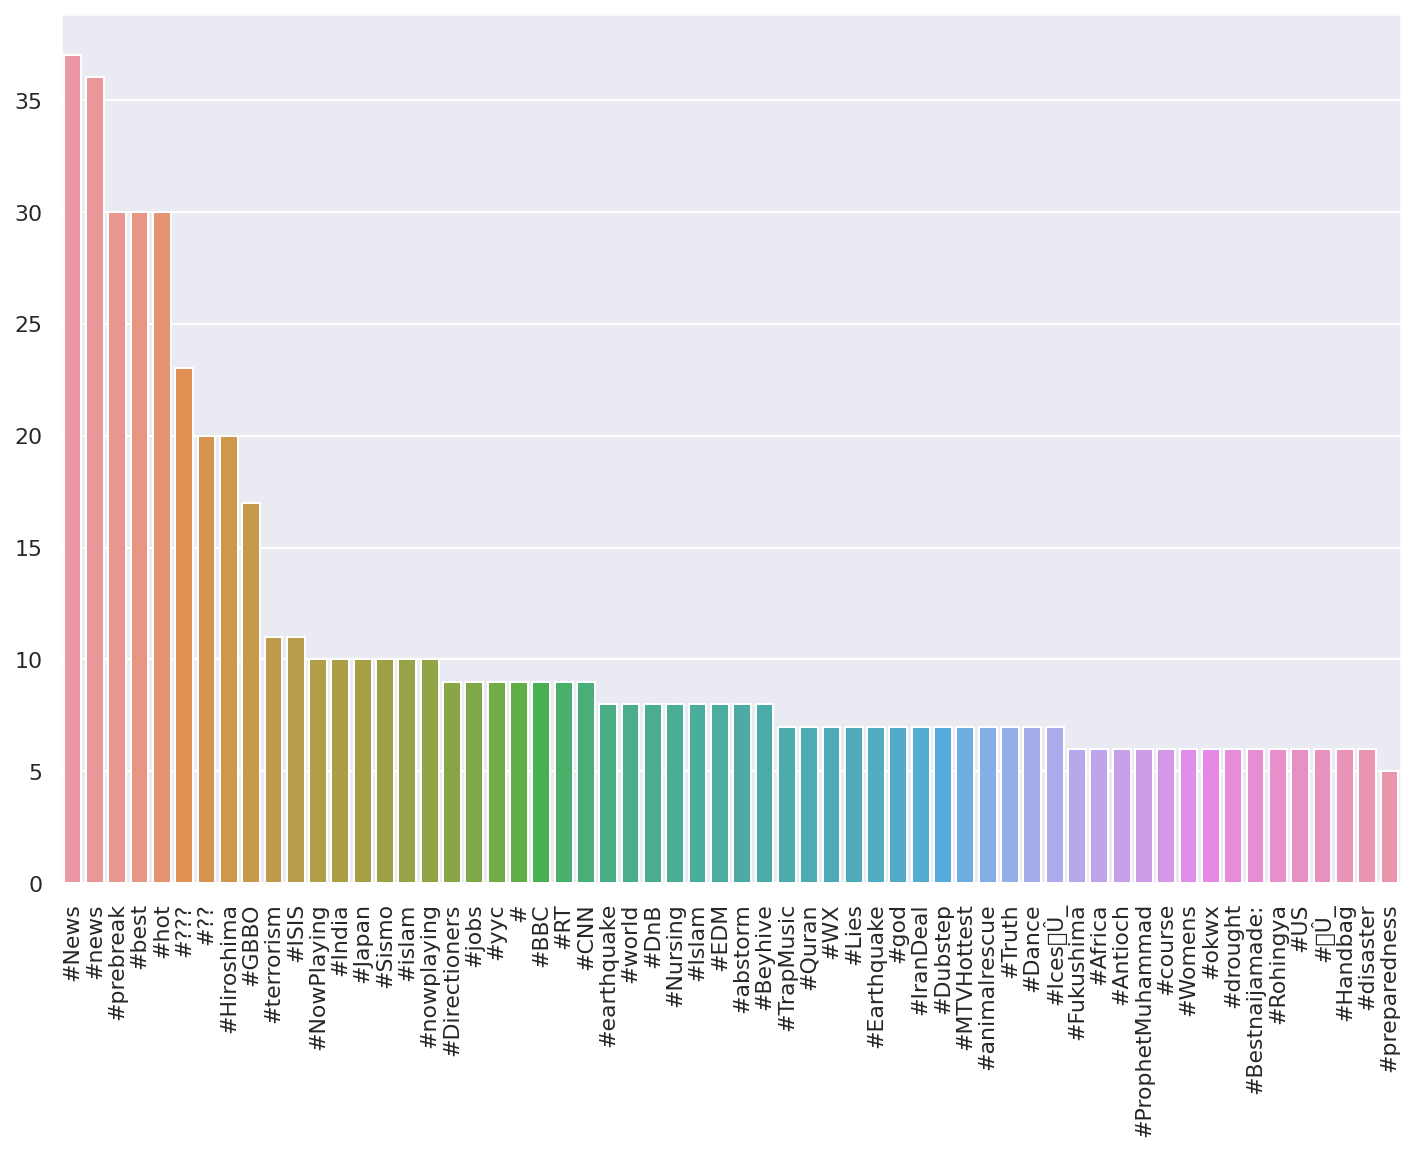

In [200]:
sns.set(font_scale=1)

amount = 60
ax = sns.barplot(x = counts.head(amount).index, y = counts.head(amount).values)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '31'),
 Text(0, 0, '42'),
 Text(0, 0, '98'),
 Text(0, 0, '235'),
 Text(0, 0, '1670')]

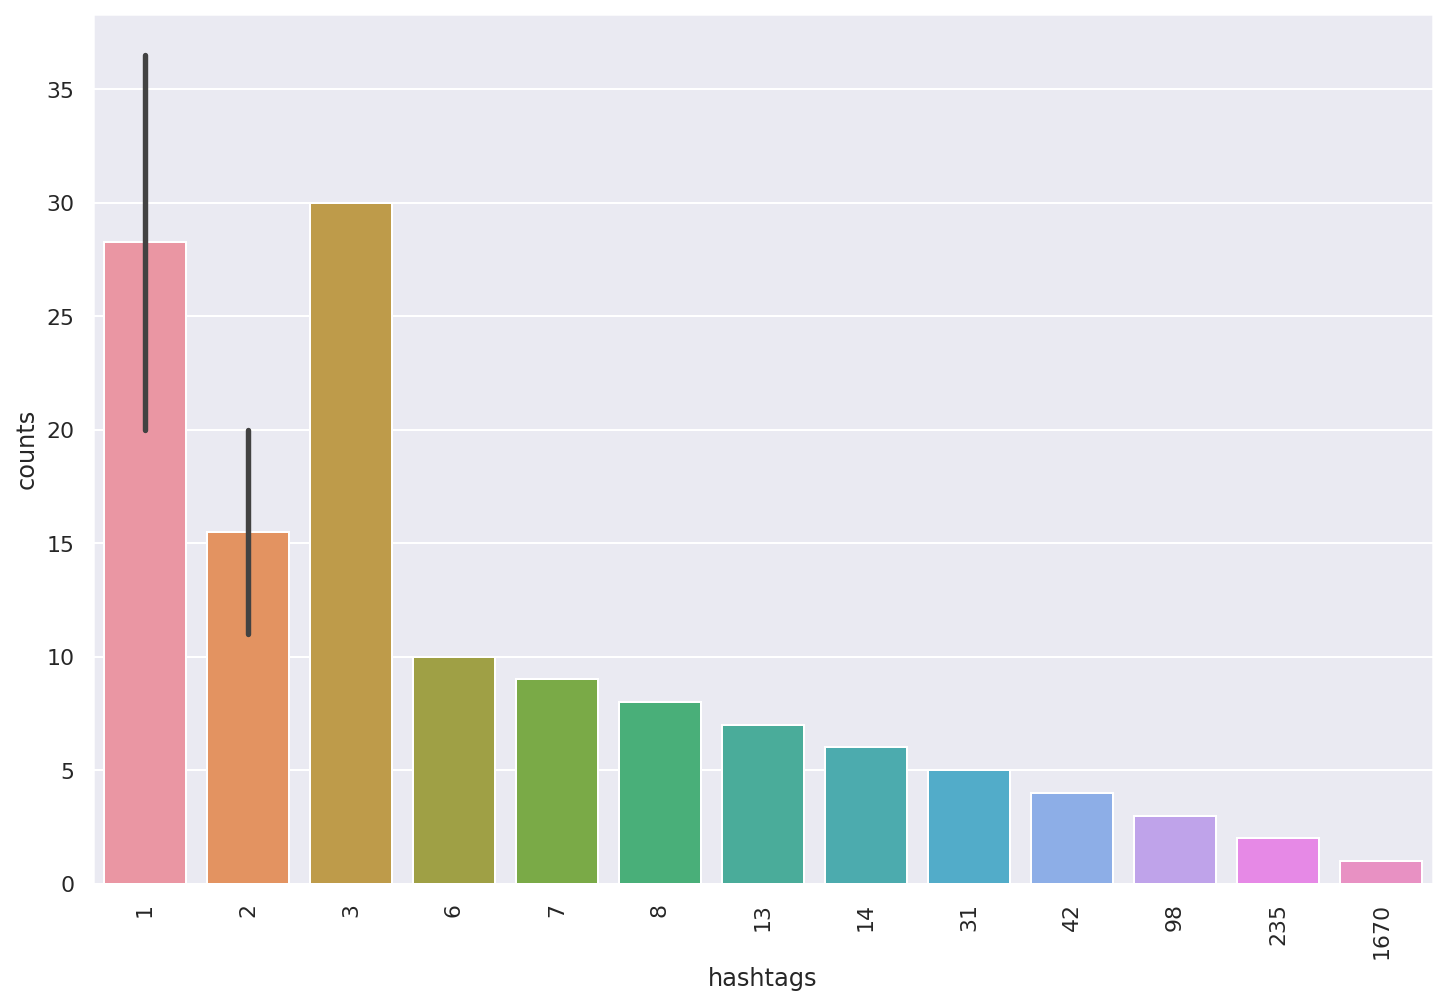

In [201]:
counts = hashtags.value_counts().to_frame().reset_index()
counts.columns = ['hashtags','counts']
counts_of_counts = counts.groupby('counts').count().reset_index()

ax = sns.barplot(x = counts_of_counts.hashtags, y = counts_of_counts.counts)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

[Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '31'),
 Text(0, 0, '42'),
 Text(0, 0, '98'),
 Text(0, 0, '235'),
 Text(0, 0, '1670')]

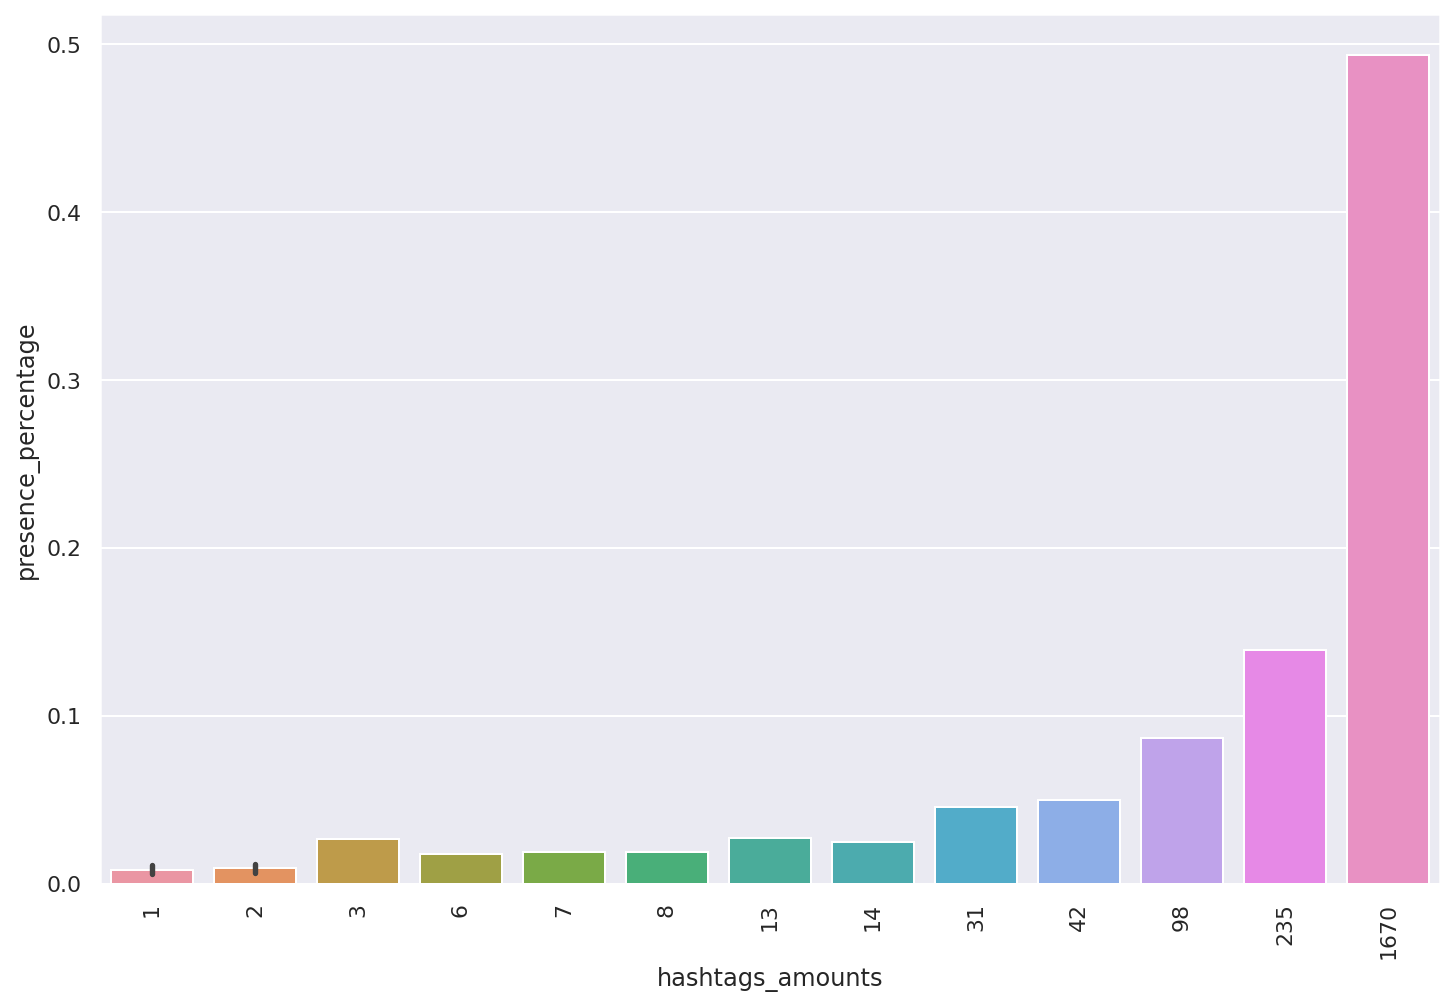

In [202]:
total_hashtags = len(hashtags)

counts_of_counts['presence_percentage'] = counts_of_counts.counts * counts_of_counts.hashtags / total_hashtags
counts_of_counts.columns = ['counts','hashtags_amounts','presence_percentage']

ax = sns.barplot(x = counts_of_counts.hashtags_amounts, y = counts_of_counts.presence_percentage)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

Vemos que algunos hashtags se usan bastante y quizas tengan importancia para predecir el label por lo que queremos quedarnoslos y hacer que nuestro modelo los aprenda.

Sin embargo hemos visto que son muchisimos y no tenemos tantos tweets como para que el modelo pudiese aprenderlos todos. Ademas, segun vemos en el grafico anterior, las clases de tweets agrupadas por probabilidad de ocurrencia siguen una power law. Esto quiere decir que la mayoria tienen poca precencia u ocurrencia, mientras que unos pocos son los que mas se usan.

Vamos a buscar a partir de que threshold de agrupamiento de tweets el porcentage de los desechados es menor a 50%

In [203]:
counts_of_counts = counts_of_counts.sort_values('presence_percentage', ascending = True).reset_index()
counts_of_counts.head()

,index,counts,hashtags_amounts,presence_percentage
0,11,17,1,0.005024
1,10,11,2,0.006501
2,13,23,1,0.006797
3,15,36,1,0.010638
4,16,37,1,0.010934


[Text(0, 0, '1'),
 Text(0, 0, '2'),
 Text(0, 0, '3'),
 Text(0, 0, '6'),
 Text(0, 0, '7'),
 Text(0, 0, '8'),
 Text(0, 0, '13'),
 Text(0, 0, '14'),
 Text(0, 0, '31'),
 Text(0, 0, '42'),
 Text(0, 0, '98'),
 Text(0, 0, '235')]

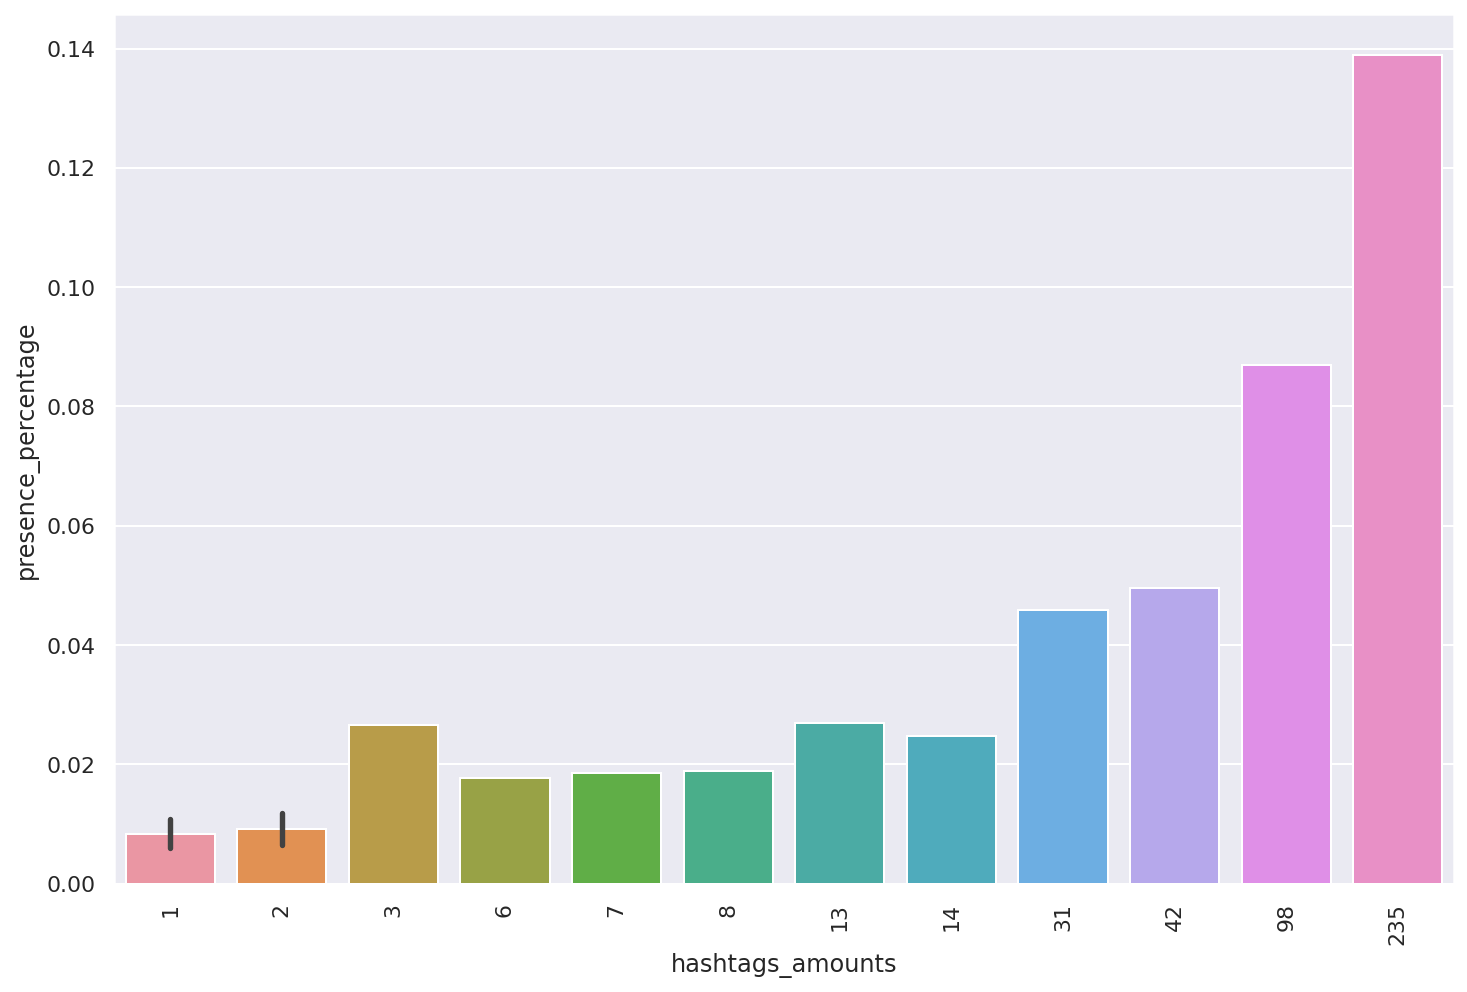

In [204]:
class_idx = 0
cumulated_prescence = 0
for idx,hashtag_class in counts_of_counts.iterrows():
    cumulated_prescence += hashtag_class.presence_percentage
    if cumulated_prescence >= 0.5:
        class_idx = idx
        break


to_filter_counts_of_counts = counts_of_counts.iloc[class_idx + 1:]
counts_of_counts = counts_of_counts.iloc[:class_idx + 1]
        
ax = sns.barplot(x = counts_of_counts.hashtags_amounts, y = counts_of_counts.presence_percentage)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)

In [205]:
print("Cantidad de hashtags que quedan: ",counts_of_counts.presence_percentage.sum() * total_hashtags)
print("Cantidad de hashtags que que habia: ",total_hashtags)
print(f"Porcentaje filtrado por baja ocurrencia: {round(1 - counts_of_counts.presence_percentage.sum(),3)*100}%")

Cantidad de hashtags que quedan:  1714.0
Cantidad de hashtags que que habia:  3384
Porcentaje filtrado por baja ocurrencia: 49.3%


Ahora que seleccionamos que hashtags filtrar vamos a proceder a crear la funcion que filtra del dataset aquellos hashtags que seleccionamos para filtrar.

En nuestro caso filtrar simplemente significa asignarle el tag HASHTAG. De este modo el 49.3% de las ocurrencias de hashtags tendran ese tag y el modelo que usemos sera mas capaz de aprender de estos.

In [ ]:
HASHTAG = 'HASHTAG'

to_filter_hashtags = counts.merge(
        to_filter_counts_of_counts, on='counts'
).hashtags.values

cleanHashtags = lambda x: HASHTAG if x in to_filter_hashtags else x

In [71]:
re.findall('[\d\W]+',corpus)

[' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' #',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '. ',
 ' ',
 ' ',
 ' ',
 ' ',
 " '",
 ' ',
 ' ',
 "' ",
 ' ',
 ' ',
 ' ',
 ' ',
 '. ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' 13,000 ',
 ' ',
 ' #',
 ' ',
 ' ',
 ' ',
 ' ',
 '  ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' #',
 ' ',
 ' ',
 ' ',
 ' #',
 ' ',
 ' ',
 ' ',
 ' ',
 '  #',
 ' ',
 ' => ',
 ' ',
 '. 20 ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' - #',
 ' #',
 ' #',
 ' #',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ', ',
 ' ',
 ' ',
 ' ',
 "'",
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '... ',
 "'",
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 "'",
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '... ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '- ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 

In [58]:
re.findall(b'\x\w*',corpus)

SyntaxError: (value error) invalid \x escape at position 0 (<ipython-input-58-874dd871a7ec>, line 1)

In [62]:
re.findall('http\S*',corpus)

['http://t.co/lHYXEOHY6C',
 'http://t.co/YAo1e0xngw',
 'http://t.co/2nndBGwyEi',
 'http://t.co/qqsmshaJ3N',
 'http://t.co/3ImaomknnA',
 'http://t.co/wDUEaj8Q4J',
 'http://t.co/rOI2NSmEJJ',
 'http://t.co/3Tj8ZjiN21',
 'http://t.co/YDUiXEfIpE',
 'http://t.co/LxTjc87KLS',
 'http://t.co/o9qknbfOFX',
 'http://t.co/TIyUliF5c6',
 'http://t.co/vl5TBR3wbr',
 'http://t.co/rOI2NSmEJJ',
 'http://t.co/3Tj8ZjiN21',
 'http://t.co/YDUiXEfIpE',
 'http://t.co/LxTjc87KLS',
 'http://t.co/gWNRhMSO8k',
 'http://t.co/eV1ahOUCZA',
 'http://t.co/vplR5Hka2u',
 'http://t.co/SxHW2TNNLf',
 'http://t.co/pcXarbH9An',
 "http://t.co/uc4j4jHvGR'",
 'http://t.co/4IzFdYC3cg',
 'http://t.co/8kscqKfKkF',
 'https://t.co/cYoMPZ1A0Z',
 'http://t.co/iCSjGZ9tE1',
 'http://t.co/9FxmN0l0Bd',
 'http://t.co/9FxPiXQuJt',
 'https://t.co/7MLMsUzV1Z',
 'http://t.co/Av2JSjfFtc',
 'http://t.co/rwzbFVNXER',
 'https://t.co/0GHk693EgJ',
 'http://t.co/pmlOhZuRWR',
 'http://t.co/GKYe6gjTk5',
 'https://t.co/k4zoMOF319',
 'https://t.co/S2kXVM0c

In [63]:
re.findall('\W',corpus)

[' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '#',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '.',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 "'",
 ' ',
 ' ',
 "'",
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '.',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ',',
 ' ',
 ' ',
 ' ',
 '#',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '#',
 ' ',
 ' ',
 ' ',
 ' ',
 '#',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '#',
 ' ',
 ' ',
 '=',
 '>',
 ' ',
 ' ',
 '.',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '-',
 ' ',
 '#',
 ' ',
 '#',
 ' ',
 '#',
 ' ',
 '#',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ',',
 ' ',
 ' ',
 ' ',
 ' ',
 "'",
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '.',
 '.',
 '.',
 ' ',
 "'",
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 "'",
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 ' ',
 '.',
 '.',
 '.',
 ' ',
 ' ',
 ' '

# Preprocesamiento

3271 4342


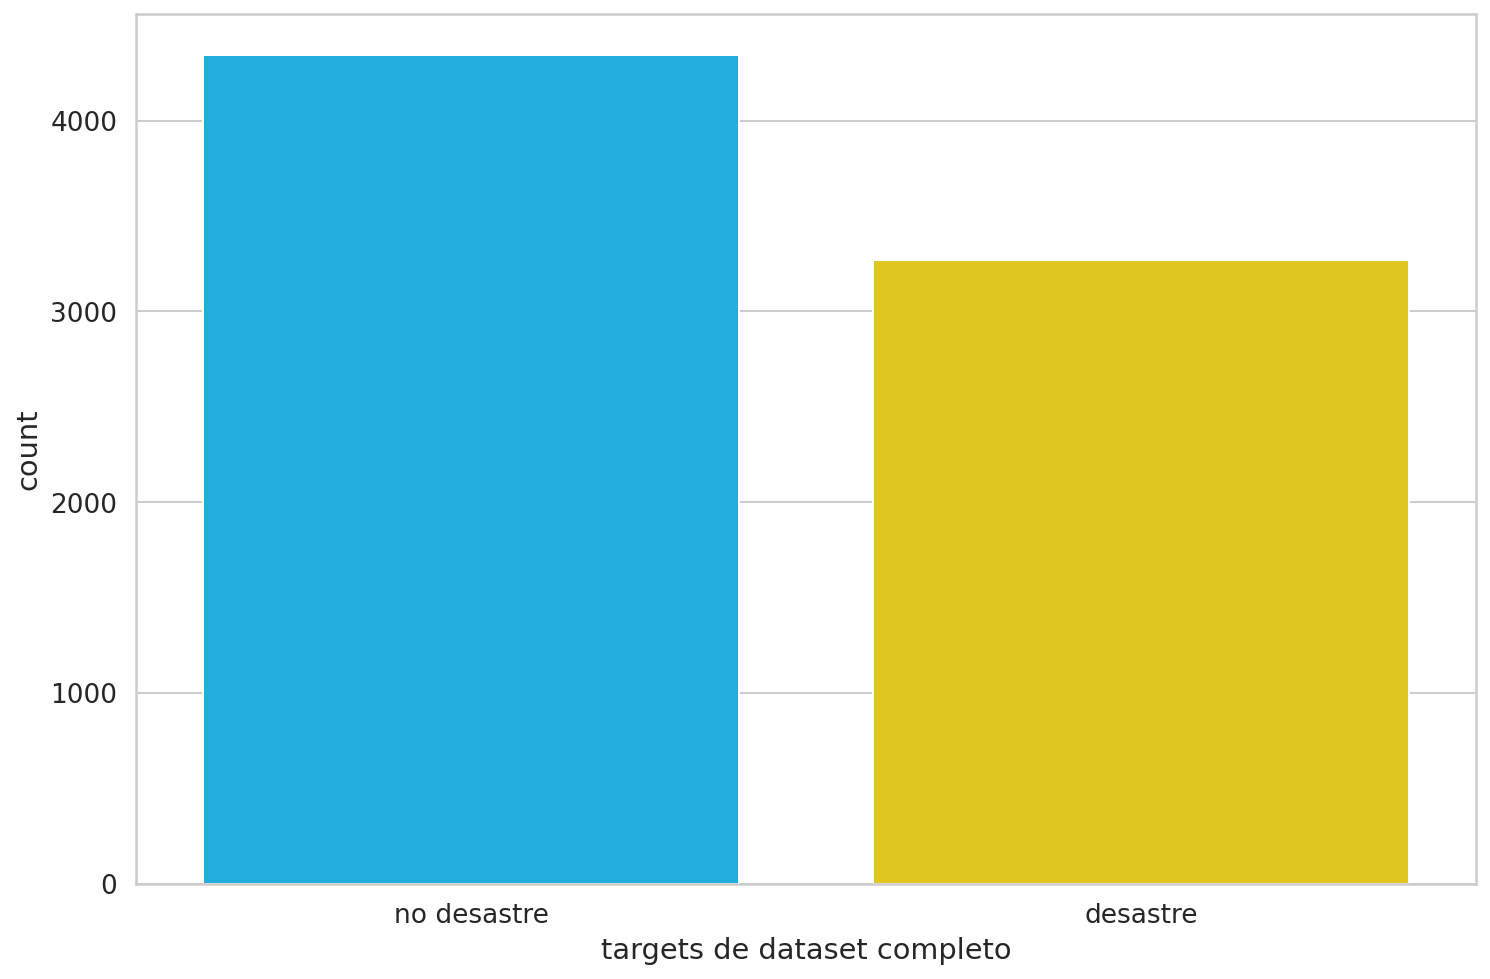

In [9]:
data['complete_text'] = data['keyword'] + ' ' + data['location'] + ' ' + data['text']

tag_1 = data[data['target'] == 1]
tag_0 = data[data['target'] == 0]


ax = sns.countplot(data.target)
plt.xlabel('targets de dataset completo')
ax.set_xticklabels(['no desastre','desastre']);
print(len(tag_1),len(tag_0))

In [10]:
#Esto es para que el set de train y val este equilibrado entre 1 y 0 y para que el 
#set de validacion tenga solo datos nuevos que no se usaron en train 

tag_1_val_size = 0.1

tag_0_val_size = 1 - (len(tag_1) * (1 - tag_1_val_size))/(len(tag_0))

tag_1_train, tag_1_val = train_test_split(tag_1, test_size = tag_1_val_size)
tag_0_train, tag_0_val = train_test_split(tag_0, test_size = tag_0_val_size)

tag_0_val = tag_0_val.sample(len(tag_1_val))

train = pd.concat([tag_1_train,tag_0_train])
val = pd.concat([tag_1_val,tag_0_val])
len(train),len(val)

(5886, 656)

In [11]:
def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)


def remove_html(text):
    html = re.compile(r"<.*?>")
    return html.sub(r"", text)

def remove_emoji(string):
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        "]+",
        flags=re.UNICODE,
    )
    return emoji_pattern.sub(r"", string)

def remove_punct(text):
    table = str.maketrans("", "", string.punctuation)
    return text.translate(table)

def remove_noise(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

train.complete_text = train.complete_text.map(lambda x: remove_URL(x))
train.complete_text = train.complete_text.map(lambda x: remove_html(x))
train.complete_text= train.complete_text.map(lambda x: remove_emoji(x))
train.complete_text = train.complete_text.map(lambda x: remove_punct(x))
train.complete_text = train.complete_text.map(lambda x: remove_noise(x))

val.complete_text = val.complete_text.map(lambda x: remove_URL(x))
val.complete_text = val.complete_text.map(lambda x: remove_html(x))
val.complete_text= val.complete_text.map(lambda x: remove_emoji(x))
val.complete_text = val.complete_text.map(lambda x: remove_punct(x))
val.complete_text = val.complete_text.map(lambda x: remove_noise(x))

# Encodeo de tweets para la red neuronal

In [12]:
module_url = "https://tfhub.dev/tensorflow/bert_en_cased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

In [13]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, False)

In [14]:
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)


x_train = bert_encode(train.complete_text.values, tokenizer, max_len=160)
x_val = bert_encode(val.complete_text.values, tokenizer, max_len=160)
y_train = train.target.values
y_val = val.target.values

porcentaje de tweets que quedan cortados: 0.01%


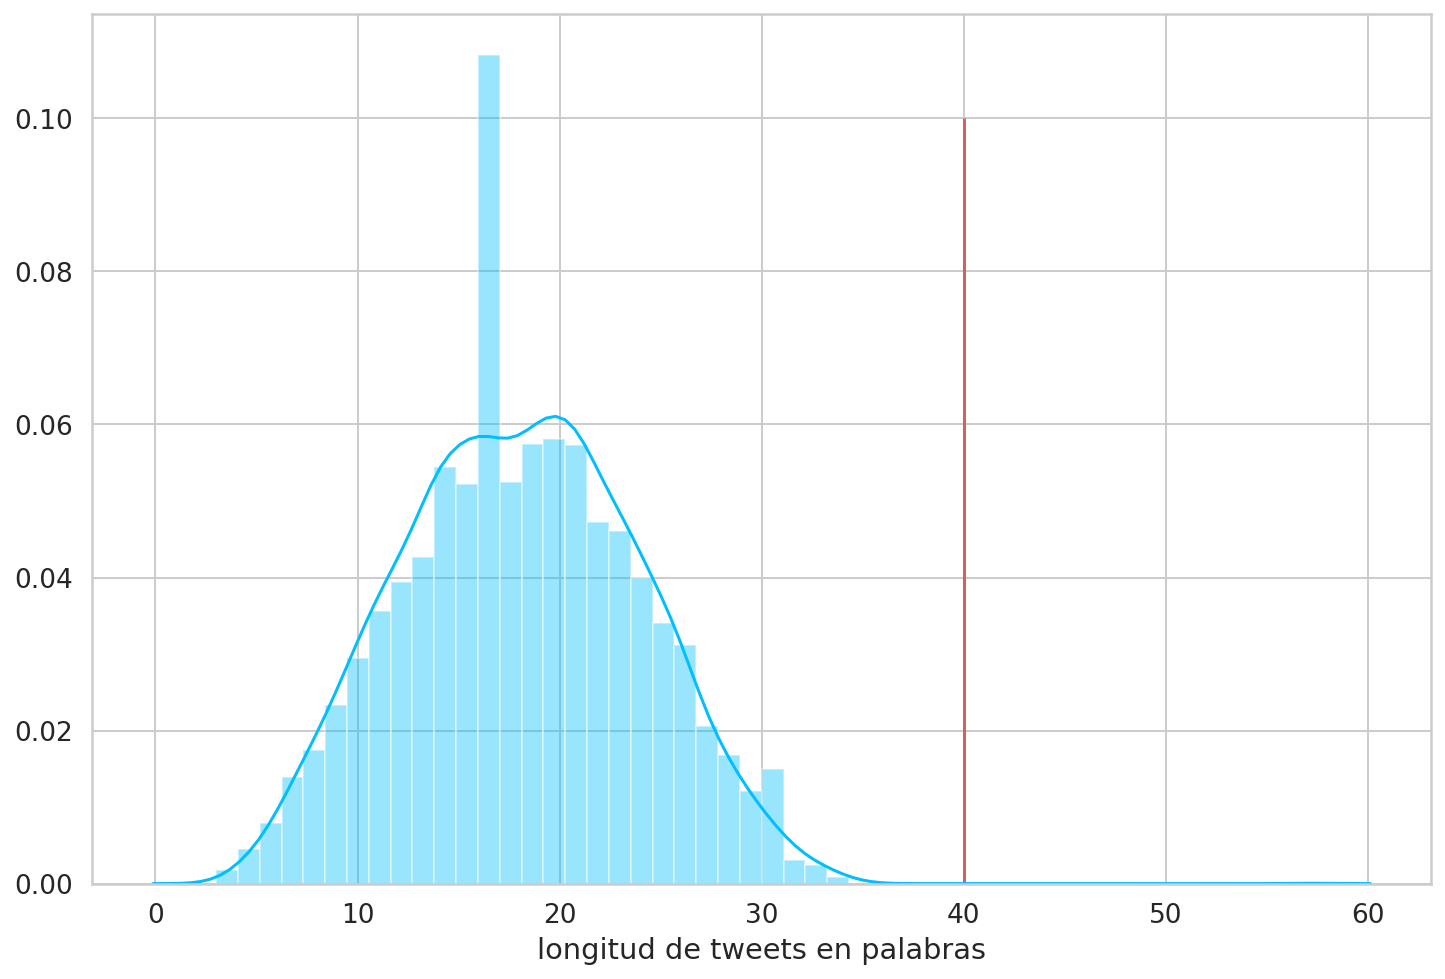

In [15]:
# La red requiere una longitud maxima y mas rapido entrena 
#cuando mas corta es la longitud por lo que estoy buscando con que longitud 
#maxima quedarme sin tirar demasiados tweets

MAX_LEN = 40

lens = data.complete_text.apply(lambda x: len(x.split(' ')) )

sns.distplot(lens)
plt.xlabel('longitud de tweets en palabras');
plt.vlines(x=MAX_LEN, ymin=0, ymax=0.1,  color = 'r')

print("porcentaje de tweets que quedan cortados: {}%".format(round(len(lens[ lens > MAX_LEN ])/len(data) * 100,2)))

In [16]:
"""
# Count unique words
def counter_word(text):
    count = Counter()
    for i in text.values:
        for word in i.split():
            count[word] += 1
    return count

counter = counter_word(train.complete_text)
num_words = len(counter)
print(num_words)"""

'\n# Count unique words\ndef counter_word(text):\n    count = Counter()\n    for i in text.values:\n        for word in i.split():\n            count[word] += 1\n    return count\n\ncounter = counter_word(train.complete_text)\nnum_words = len(counter)\nprint(num_words)'

In [17]:
"""
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(train.complete_text)
word_index = tokenizer.word_index
"""

'\ntokenizer = Tokenizer(num_words=num_words)\ntokenizer.fit_on_texts(train.complete_text)\nword_index = tokenizer.word_index\n'

In [18]:
"""
x_train = pad_sequences(
    tokenizer.texts_to_sequences(train.complete_text),
    maxlen=MAX_LEN,
    padding="post",
    truncating="post"
)

x_val = pad_sequences(
    tokenizer.texts_to_sequences(val.complete_text),
    maxlen=MAX_LEN,
    padding="post",
    truncating="post"
)

x_train = np.array([np.array_split(tweet, MAX_LEN) for tweet in x_train])
x_val = np.array([np.array_split(tweet, MAX_LEN) for tweet in x_val])

y_train = np.array(train.target)
y_val = np.array(val.target)
"""

'\nx_train = pad_sequences(\n    tokenizer.texts_to_sequences(train.complete_text),\n    maxlen=MAX_LEN,\n    padding="post",\n    truncating="post"\n)\n\nx_val = pad_sequences(\n    tokenizer.texts_to_sequences(val.complete_text),\n    maxlen=MAX_LEN,\n    padding="post",\n    truncating="post"\n)\n\nx_train = np.array([np.array_split(tweet, MAX_LEN) for tweet in x_train])\nx_val = np.array([np.array_split(tweet, MAX_LEN) for tweet in x_val])\n\ny_train = np.array(train.target)\ny_val = np.array(val.target)\n'

# Creacion de modelo

In [19]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [20]:
model = build_model(bert_layer, max_len=160)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 333579265   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [21]:
"""
EMBEDED_SPACE=100
LSTM_UNITS = 256

model = Sequential()
model.add(Flatten(input_shape=(x_train.shape[1:])))
model.add(Embedding(num_words, EMBEDED_SPACE, input_length=MAX_LEN))
model.add(Conv1D(128,2))
model.add(Conv1D(128,3))
model.add(LSTM(LSTM_UNITS,input_shape=(EMBEDED_SPACE,1), return_sequences=True))
model.add(LSTM(LSTM_UNITS,input_shape=(EMBEDED_SPACE,1), return_sequences=True))
model.add(Dropout(0.2, noise_shape=None, seed=None))
model.add(LSTM(LSTM_UNITS,input_shape=(EMBEDED_SPACE,1), return_sequences=True))
model.add(Dropout(0.2, noise_shape=None, seed=None))
model.add(LSTM(LSTM_UNITS//2,input_shape=(EMBEDED_SPACE,1), return_sequences=True))
model.add(Dense(64, activation='relu'))
model.add(Flatten(input_shape=(MAX_LEN,256)))
model.add(Dense(1, activation='sigmoid'))

optimizer = Adam(learning_rate=5e-6)

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

model.summary()
"""

"\nEMBEDED_SPACE=100\nLSTM_UNITS = 256\n\nmodel = Sequential()\nmodel.add(Flatten(input_shape=(x_train.shape[1:])))\nmodel.add(Embedding(num_words, EMBEDED_SPACE, input_length=MAX_LEN))\nmodel.add(Conv1D(128,2))\nmodel.add(Conv1D(128,3))\nmodel.add(LSTM(LSTM_UNITS,input_shape=(EMBEDED_SPACE,1), return_sequences=True))\nmodel.add(LSTM(LSTM_UNITS,input_shape=(EMBEDED_SPACE,1), return_sequences=True))\nmodel.add(Dropout(0.2, noise_shape=None, seed=None))\nmodel.add(LSTM(LSTM_UNITS,input_shape=(EMBEDED_SPACE,1), return_sequences=True))\nmodel.add(Dropout(0.2, noise_shape=None, seed=None))\nmodel.add(LSTM(LSTM_UNITS//2,input_shape=(EMBEDED_SPACE,1), return_sequences=True))\nmodel.add(Dense(64, activation='relu'))\nmodel.add(Flatten(input_shape=(MAX_LEN,256)))\nmodel.add(Dense(1, activation='sigmoid'))\n\noptimizer = Adam(learning_rate=5e-6)\n\nmodel.compile(loss='binary_crossentropy',\n              optimizer=optimizer,\n              metrics=['accuracy'])\n\nmodel.summary()\n"

# Entrenando modelo

In [22]:
TRIAL = 0

In [23]:
checkpoint = ModelCheckpoint(filepath=str(TRIAL)+'.h5', monitor='val_accuracy', save_best_only=True, verbose = 1)

Epoch 1/5
368/368 [==============================] - ETA: 0s - loss: 0.4540 - accuracy: 0.7931
Epoch 00001: val_accuracy improved from -inf to 0.83384, saving model to 0.h5
368/368 [==============================] - 383s 1s/step - loss: 0.4540 - accuracy: 0.7931 - val_loss: 0.3941 - val_accuracy: 0.8338
Epoch 2/5
368/368 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.8801
Epoch 00002: val_accuracy improved from 0.83384 to 0.84146, saving model to 0.h5
368/368 [==============================] - 378s 1s/step - loss: 0.3024 - accuracy: 0.8801 - val_loss: 0.3993 - val_accuracy: 0.8415
Epoch 3/5
368/368 [==============================] - ETA: 0s - loss: 0.1964 - accuracy: 0.9242
Epoch 00003: val_accuracy did not improve from 0.84146
368/368 [==============================] - 345s 938ms/step - loss: 0.1964 - accuracy: 0.9242 - val_loss: 0.5386 - val_accuracy: 0.8186
Epoch 4/5
368/368 [==============================] - ETA: 0s - loss: 0.1026 - accuracy: 0.9619
Epoch 0

(0.0, 1.0)

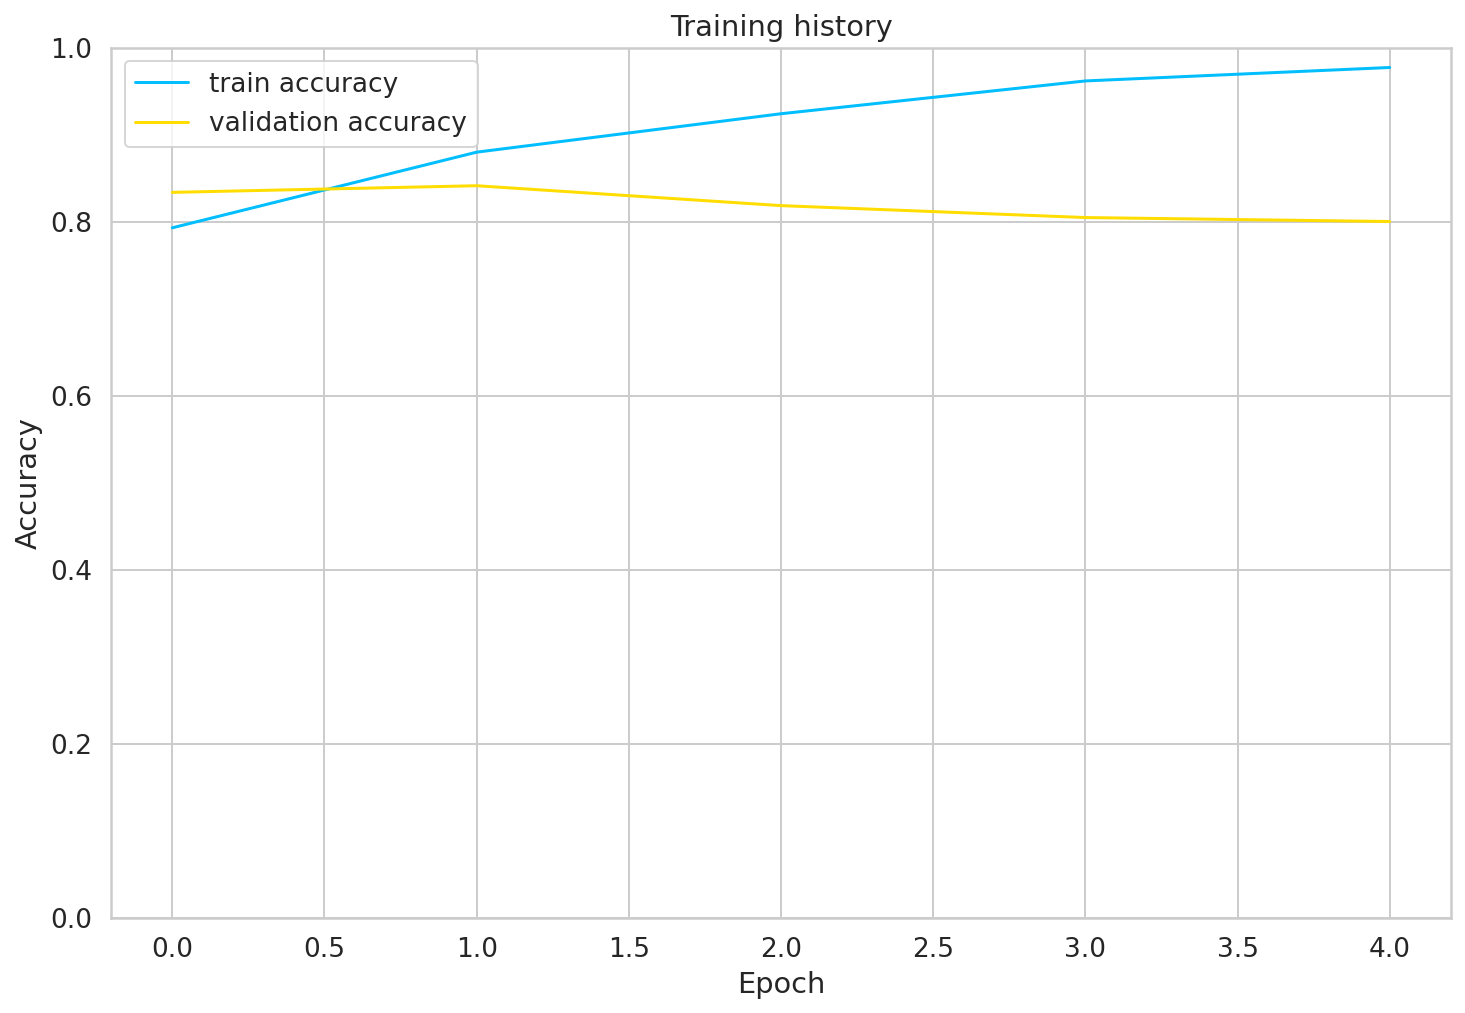

In [24]:
history = model.fit(x_train,y_train, epochs=5, validation_data=(x_val,y_val),
                    callbacks=[checkpoint],batch_size=16)
TRIAL += 1


plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

(0.0, 1.0)

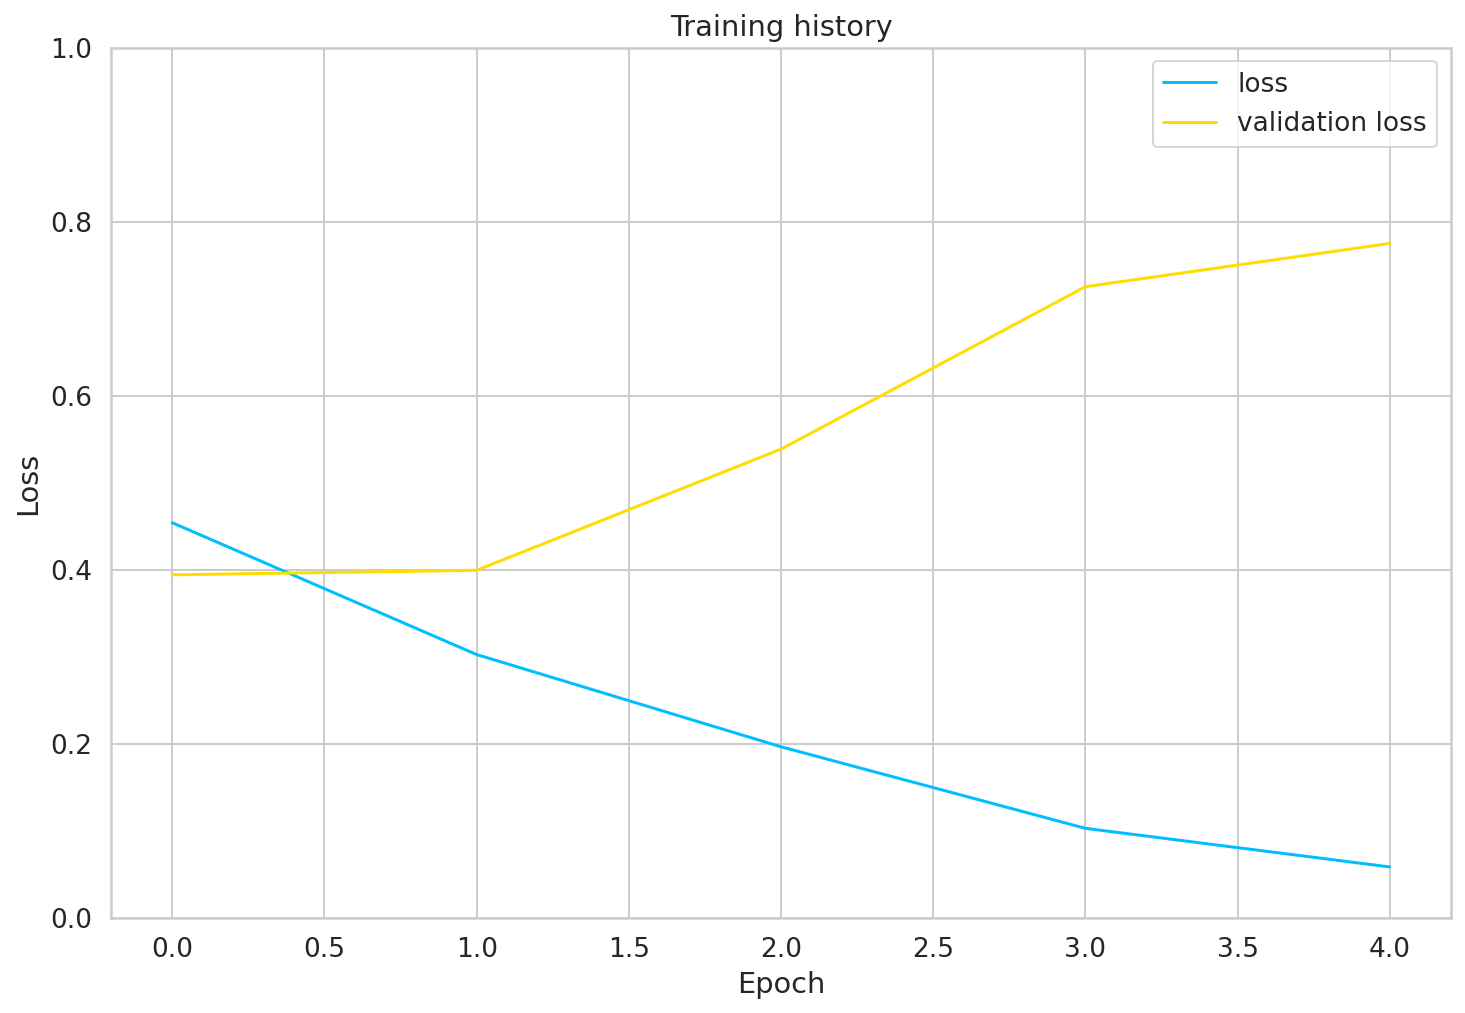

In [25]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1])

# Evaluacion

In [33]:
model.load_weights(str(TRIAL - 1)+'.h5')
preds = model.predict(x_val)

In [34]:
mapProbs = lambda x: 1 if x>=0.5 else 0

In [37]:
real_preds = []
for p in preds:
    real_preds.append(mapProbs(p))

In [38]:
print(metrics.classification_report(y_val, real_preds,zero_division = 0))
print('F1 score: ',metrics.f1_score(y_val, real_preds, zero_division = 0))

              precision    recall  f1-score   support

           0       0.81      0.89      0.85       328
           1       0.88      0.79      0.83       328

    accuracy                           0.84       656
   macro avg       0.84      0.84      0.84       656
weighted avg       0.84      0.84      0.84       656

F1 score:  0.8333333333333334


In [39]:
to_predict.complete_text = to_predict.complete_text.map(lambda x: remove_URL(x))
to_predict.complete_text = to_predict.complete_text.map(lambda x: remove_html(x))
to_predict.complete_text= to_predict.complete_text.map(lambda x: remove_emoji(x))
to_predict.complete_text = to_predict.complete_text.map(lambda x: remove_punct(x))
to_predict.complete_text = to_predict.complete_text.map(lambda x: remove_noise(x))

In [40]:
x_to_predict = bert_encode(to_predict.complete_text.values, tokenizer, max_len=160)

In [41]:
preds = model.predict(x_to_predict)
real_preds = []
for p in preds:
    real_preds.append(mapProbs(p))

[0,
 2,
 3,
 9,
 11,
 12,
 21,
 22,
 27,
 29,
 30,
 35,
 42,
 43,
 45,
 46,
 47,
 51,
 58,
 60,
 69,
 70,
 72,
 75,
 84,
 87,
 88,
 90,
 94,
 99,
 101,
 103,
 106,
 108,
 111,
 115,
 116,
 122,
 123,
 124,
 125,
 127,
 140,
 142,
 147,
 148,
 150,
 152,
 154,
 155,
 166,
 167,
 169,
 177,
 179,
 181,
 186,
 188,
 189,
 192,
 200,
 202,
 206,
 207,
 214,
 217,
 223,
 224,
 227,
 228,
 230,
 233,
 234,
 236,
 239,
 250,
 255,
 257,
 259,
 275,
 278,
 282,
 284,
 286,
 288,
 292,
 295,
 300,
 304,
 305,
 306,
 308,
 311,
 317,
 319,
 323,
 324,
 325,
 326,
 333,
 339,
 342,
 343,
 350,
 351,
 357,
 359,
 362,
 366,
 367,
 369,
 373,
 374,
 376,
 377,
 378,
 379,
 382,
 385,
 387,
 388,
 391,
 392,
 395,
 399,
 400,
 403,
 405,
 408,
 411,
 414,
 416,
 417,
 422,
 425,
 428,
 430,
 431,
 433,
 434,
 439,
 441,
 449,
 458,
 460,
 464,
 473,
 488,
 491,
 494,
 497,
 500,
 505,
 507,
 508,
 510,
 511,
 515,
 525,
 529,
 532,
 534,
 537,
 539,
 541,
 545,
 547,
 548,
 549,
 553,
 554,
 555,
 5

In [57]:
submit = pd.DataFrame({
    'id': list(to_predict.id),
    'target': real_preds
})
submit

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,1


In [58]:
submit.to_csv('BERT_keras_1.csv', index=False)